### **Does Idiosyncratic Volatility Affect Stock Return?**

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 18 00:47:01 2021

@author: Bradley

Code for recurring FIN3080 Project 2 - Case 2
"""

'\nCreated on Sat July 18 00:47:01 2021\n\n@author: Bradley\n\nCode for recurring FIN3080 Project 2 - Case 2\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 

### **Effect of Idiosyncratic Volatility (IVOL) on Stock Returns**

#### **数据预处理**

In [3]:
# 仍然使用个股月度数据，2006年到2021年
month = pd.read_csv('./case2_data/TRD_Mnth.csv')
month.columns = ['code', 'date', 'return', 'type']
month['code'] = month['code'].map(lambda x: '%06d'%x)
month['date'] = pd.to_datetime(month['date'])
month

,code,date,return,type
0,000001,2006-01-01,0.034202,4
1,000001,2006-02-01,0.077165,4
2,000001,2006-03-01,-0.068713,4
3,000001,2006-04-01,0.237049,4
4,000001,2006-05-01,0.114213,4
...,...,...,...,...
453973,900957,2020-08-01,-0.058722,2
453974,900957,2020-09-01,-0.060550,2
453975,900957,2020-10-01,0.005859,2
453976,900957,2020-11-01,0.013592,2


In [4]:
# 处理无风险利率的格式
riskfree = pd.read_csv('./case2_data/TRD_Nrrate.csv')
riskfree.columns = ['base', 'date', 'return']
riskfree['date'] = pd.to_datetime(riskfree['date'])
riskfree

,base,date,return
0,NRI01,2006-01-01,0.1856
1,NRI01,2006-01-02,0.1856
2,NRI01,2006-01-03,0.1856
3,NRI01,2006-01-04,0.1856
4,NRI01,2006-01-05,0.1856
...,...,...,...
5474,NRI01,2020-12-27,0.1241
5475,NRI01,2020-12-28,0.1241
5476,NRI01,2020-12-29,0.1241
5477,NRI01,2020-12-30,0.1241


In [5]:
riskfree['base'].unique()

array(['NRI01'], dtype=object)

In [6]:
riskfree['month'] = riskfree['date'].dt.month
riskfree['year'] = riskfree['date'].dt.year
riskfree['year-month'] = riskfree.apply(lambda s: f"{s['year']}-{s['month']:02}", 1)
riskfree = riskfree.drop_duplicates('year-month')
riskfree['date'] = pd.to_datetime(riskfree['year-month'])
riskfree = riskfree.drop(['base', 'year', 'month', 'year-month'], 1)
riskfree['return'] = riskfree['return']/100
riskfree.head(10)

,date,return
0,2006-01-01,0.001856
31,2006-02-01,0.001856
59,2006-03-01,0.001856
90,2006-04-01,0.001856
120,2006-05-01,0.001856
151,2006-06-01,0.001856
181,2006-07-01,0.001856
212,2006-08-01,0.001856
243,2006-09-01,0.002076
273,2006-10-01,0.002076


In [7]:
# 使用assert命令检查下是否数据是按照date顺序排列过的
assert riskfree['date'].to_numpy().tolist() == sorted(riskfree['date'].to_numpy().tolist()), 'data is not sorted by month'
riskfree.isnull().sum()

date      0
return    0
dtype: int64

In [8]:
riskfree = riskfree.reset_index(drop=True)
riskfree.head(10)

,date,return
0,2006-01-01,0.001856
1,2006-02-01,0.001856
2,2006-03-01,0.001856
3,2006-04-01,0.001856
4,2006-05-01,0.001856
5,2006-06-01,0.001856
6,2006-07-01,0.001856
7,2006-08-01,0.001856
8,2006-09-01,0.002076
9,2006-10-01,0.002076


In [9]:
# CSMAR数据库的fama三因子值，也可以下载五因子的，结果一样，取决于
market = pd.read_csv('./case2_data/STK_MKT_THRFACMONTH.csv')
market.columns = ['type', 'date', 'return', 'smb', 'hml']
market = market[market['type'] == 'P9715']
market['date'] = pd.to_datetime(market['date'])
# market = market.drop(['type', 'smb', 'hml'], axis=1)
market.head(10)

,type,date,return,smb,hml
6,P9715,2006-01-01,0.103575,-0.000453,-0.021167
14,P9715,2006-02-01,0.035575,-0.017297,0.002323
22,P9715,2006-03-01,0.012575,-0.011577,-0.017435
30,P9715,2006-04-01,0.117575,-0.044373,0.032558
38,P9715,2006-05-01,0.158575,0.120915,-0.012703
46,P9715,2006-06-01,0.027575,0.049681,-0.010138
54,P9715,2006-07-01,-0.053425,0.041151,-0.012809
62,P9715,2006-08-01,0.020500,0.001149,-0.019782
70,P9715,2006-09-01,0.053500,0.047749,-0.023247
78,P9715,2006-10-01,0.030500,-0.062020,0.044337


In [10]:
assert market['date'].to_numpy().tolist() == sorted(market['date'].to_numpy().tolist()), 'data is not sorted by month'
market = market.reset_index(drop=True)
market.head(10)
market.isnull().sum()

,type,date,return,smb,hml
0,P9715,2006-01-01,0.103575,-0.000453,-0.021167
1,P9715,2006-02-01,0.035575,-0.017297,0.002323
2,P9715,2006-03-01,0.012575,-0.011577,-0.017435
3,P9715,2006-04-01,0.117575,-0.044373,0.032558
4,P9715,2006-05-01,0.158575,0.120915,-0.012703
5,P9715,2006-06-01,0.027575,0.049681,-0.010138
6,P9715,2006-07-01,-0.053425,0.041151,-0.012809
7,P9715,2006-08-01,0.020500,0.001149,-0.019782
8,P9715,2006-09-01,0.053500,0.047749,-0.023247
9,P9715,2006-10-01,0.030500,-0.062020,0.044337


type      0
date      0
return    0
smb       0
hml       0
dtype: int64

In [11]:
market.head()
month.head()
riskfree.head()

,type,date,return,smb,hml
0,P9715,2006-01-01,0.103575,-0.000453,-0.021167
1,P9715,2006-02-01,0.035575,-0.017297,0.002323
2,P9715,2006-03-01,0.012575,-0.011577,-0.017435
3,P9715,2006-04-01,0.117575,-0.044373,0.032558
4,P9715,2006-05-01,0.158575,0.120915,-0.012703


,code,date,return,type
0,000001,2006-01-01,0.034202,4
1,000001,2006-02-01,0.077165,4
2,000001,2006-03-01,-0.068713,4
3,000001,2006-04-01,0.237049,4
4,000001,2006-05-01,0.114213,4


,date,return
0,2006-01-01,0.001856
1,2006-02-01,0.001856
2,2006-03-01,0.001856
3,2006-04-01,0.001856
4,2006-05-01,0.001856


In [12]:
data = month.copy()
data.sort_values(by=['date', 'code'], inplace=True)
data.set_index('date', inplace=True)
data['riskfree'] = riskfree.set_index('date')['return']
data[['market', 'smb', 'hml']] = market.set_index('date')[['return', 'smb', 'hml']]
data

,code,return,type,riskfree,market,smb,hml
date,,,,,,,
2006-01-01,000001,0.034202,4,0.001856,0.103575,-0.000453,-0.021167
2006-01-01,000002,0.143852,4,0.001856,0.103575,-0.000453,-0.021167
2006-01-01,000004,0.012077,4,0.001856,0.103575,-0.000453,-0.021167
2006-01-01,000005,0.018293,4,0.001856,0.103575,-0.000453,-0.021167
2006-01-01,000006,0.570960,4,0.001856,0.103575,-0.000453,-0.021167
...,...,...,...,...,...,...,...
2020-12-01,900948,0.102362,2,0.001241,0.021083,-0.052988,-0.050214
2020-12-01,900952,0.025316,2,0.001241,0.021083,-0.052988,-0.050214
2020-12-01,900953,0.024000,2,0.001241,0.021083,-0.052988,-0.050214


In [13]:
data.reset_index(inplace=True)
data.sort_values(by=['code', 'date'], inplace=True)
data

,date,code,return,type,riskfree,market,smb,hml
0,2006-01-01,000001,0.034202,4,0.001856,0.103575,-0.000453,-0.021167
1432,2006-02-01,000001,0.077165,4,0.001856,0.035575,-0.017297,0.002323
2869,2006-03-01,000001,-0.068713,4,0.001856,0.012575,-0.011577,-0.017435
4298,2006-04-01,000001,0.237049,4,0.001856,0.117575,-0.044373,0.032558
5710,2006-05-01,000001,0.114213,4,0.001856,0.158575,0.120915,-0.012703
...,...,...,...,...,...,...,...,...
437330,2020-08-01,900957,-0.058722,2,0.001241,0.017083,0.015042,-0.015729
441448,2020-09-01,900957,-0.060550,2,0.001241,-0.055917,-0.019415,0.011966
445591,2020-10-01,900957,0.005859,2,0.001241,0.012083,-0.007544,-0.016605
449758,2020-11-01,900957,0.013592,2,0.001241,0.042083,-0.036745,0.039776


#### **第一步：滑动回归计算IVOL因子值**

In [5]:
# 超参数设置
past_range = 24 # use past 24 month to calculate idiosyncratic risk and form tracting portfolio
groups = 5 # construct 5 portfolio

In [14]:
def get_ivol(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    return results.mse_resid ** 0.5

def get_idio_risks(df: pd.DataFrame,factors: pd.DataFrame):
    sigmas = df.apply(lambda s: get_ivol(s.to_numpy(), factors.to_numpy()))
    sigmas = pd.DataFrame({
        'code': sigmas.index,
        'sigma': sigmas.to_numpy()
    })
    return sigmas

In [39]:
# 第一步，计算因子值，也就是每个个股的ivol的值
# 需要对每个月的每个个股实现一个滑动的三因子回归然后得到IVOL因子值

# 思来想去，此处需要对每只股票每个时间段做滑动的回归，应该是不能写成apply的形式了，因此循环使用比for循环快些的iterrows方法提速，当然下面的apply可以使用swifter提速
def get_regression(df):
    df.reset_index(inplace=True)
    for index, row in df.iterrows():
        if index < past_range-1:
            df.loc[index, 'ivol'] = None
        else:
            short_df = df.iloc[index-past_range+1: index+1, ]
            df.loc[index, 'ivol'] = get_ivol(short_df['return'].to_numpy(), short_df[['market', 'smb', 'hml']].to_numpy())
    return df.set_index('date')['ivol']

# 选一组数目少的测试逻辑
# sub_data = data[data['code'].str.startswith('9')]
# reg = sub_data.groupby('code').apply(get_regression)
# a = sub_data.set_index(['code', 'date'])
# a['ivol'] = reg
# a

# 在整个数据集合上跑（使用了apply加上iterrows，四十五万数据五分钟）：
reg = data.groupby('code').apply(get_regression)
reg

code    date      
000001  2006-01-01         NaN
        2006-02-01         NaN
        2006-03-01         NaN
        2006-04-01         NaN
        2006-05-01         NaN
                        ...   
900957  2020-08-01    0.072652
        2020-09-01    0.073379
        2020-10-01    0.073477
        2020-11-01    0.073990
        2020-12-01    0.072552
Name: ivol, Length: 453978, dtype: float64

In [40]:
# 牛逼的双index匹配
data.set_index(['code', 'date'], inplace=True)
data['ivol'] = reg
data
# 至此，因子计算完成

return  type  riskfree    market       smb       hml      ivol
code   date                                                                        
000001 2006-01-01  0.034202     4  0.001856  0.103575 -0.000453 -0.021167       NaN
       2006-02-01  0.077165     4  0.001856  0.035575 -0.017297  0.002323       NaN
       2006-03-01 -0.068713     4  0.001856  0.012575 -0.011577 -0.017435       NaN
       2006-04-01  0.237049     4  0.001856  0.117575 -0.044373  0.032558       NaN
       2006-05-01  0.114213     4  0.001856  0.158575  0.120915 -0.012703       NaN
...                     ...   ...       ...       ...       ...       ...       ...
900957 2020-08-01 -0.058722     2  0.001241  0.017083  0.015042 -0.015729  0.072652
       2020-09-01 -0.060550     2  0.001241 -0.055917 -0.019415  0.011966  0.073379
       2020-10-01  0.005859     2  0.001241  0.012083 -0.007544 -0.016605  0.073477
       2020-11-01  0.013592     2  0.001241  0.042083 -0.036745  0.039776  0.073990
       2020-12-01 -0.036398     2  0.001241  0.021083 -0.052988 -0.050214  0.072552

[453978 rows x 7 columns]

In [41]:
# 结果得之不易，保存因子结果
data.reset_index(inplace=True)
data.pop('type')
data.to_csv("./processed_data/case2_IVOL.csv", index=False)
data

0         4
1         4
2         4
3         4
4         4
         ..
453973    2
453974    2
453975    2
453976    2
453977    2
Name: type, Length: 453978, dtype: int64

,code,date,return,riskfree,market,smb,hml,ivol
0,000001,2006-01-01,0.034202,0.001856,0.103575,-0.000453,-0.021167,NaN
1,000001,2006-02-01,0.077165,0.001856,0.035575,-0.017297,0.002323,NaN
2,000001,2006-03-01,-0.068713,0.001856,0.012575,-0.011577,-0.017435,NaN
3,000001,2006-04-01,0.237049,0.001856,0.117575,-0.044373,0.032558,NaN
4,000001,2006-05-01,0.114213,0.001856,0.158575,0.120915,-0.012703,NaN
...,...,...,...,...,...,...,...,...
453973,900957,2020-08-01,-0.058722,0.001241,0.017083,0.015042,-0.015729,0.072652
453974,900957,2020-09-01,-0.060550,0.001241,-0.055917,-0.019415,0.011966,0.073379
453975,900957,2020-10-01,0.005859,0.001241,0.012083,-0.007544,-0.016605,0.073477
453976,900957,2020-11-01,0.013592,0.001241,0.042083,-0.036745,0.039776,0.073990


#### **第二步：分组**

In [2]:
data = pd.read_csv("./processed_data/case2_IVOL.csv")
data['code'] = data['code'].map(lambda x: '%06d'%x)
data['date'] = pd.to_datetime(data['date'])

data.dropna(subset=['ivol'], inplace=True)
# 每个月根据因子值分组
data.set_index('code', inplace=True)
data['pct'] = data.groupby('date')['ivol'].rank(pct=True)
data

# 可以看到最早就是2007年12月，因为我们用的是前24个月的数据

,date,return,riskfree,market,smb,hml,ivol,pct
code,,,,,,,,
000001,2007-12-01,0.069845,0.003169,0.072225,0.070680,0.005325,0.119360,0.404715
000001,2008-01-01,-0.137306,0.003386,-0.168775,0.073161,-0.029331,0.118333,0.385382
000001,2008-02-01,-0.004505,0.003386,-0.001775,0.073890,0.020909,0.118353,0.378378
000001,2008-03-01,-0.149321,0.003386,-0.199775,-0.002471,-0.040237,0.115780,0.348998
000001,2008-04-01,0.050355,0.003386,0.063225,-0.094830,-0.011102,0.116531,0.372907
...,...,...,...,...,...,...,...,...
900957,2020-08-01,-0.058722,0.001241,0.017083,0.015042,-0.015729,0.072652,0.306793
900957,2020-09-01,-0.060550,0.001241,-0.055917,-0.019415,0.011966,0.073379,0.312031
900957,2020-10-01,0.005859,0.001241,0.012083,-0.007544,-0.016605,0.073477,0.311685


In [3]:
# 每期的因子IVOL值为根据当前以及之前的数据算的，所以需要知道下期的收益率
data['next_return'] = data.groupby(level=0)['return'].shift(-1)
data.reset_index(inplace=True)
data

,code,date,return,riskfree,market,smb,hml,ivol,pct,next_return
0,000001,2007-12-01,0.069845,0.003169,0.072225,0.070680,0.005325,0.119360,0.404715,-0.137306
1,000001,2008-01-01,-0.137306,0.003386,-0.168775,0.073161,-0.029331,0.118333,0.385382,-0.004505
2,000001,2008-02-01,-0.004505,0.003386,-0.001775,0.073890,0.020909,0.118353,0.378378,-0.149321
3,000001,2008-03-01,-0.149321,0.003386,-0.199775,-0.002471,-0.040237,0.115780,0.348998,0.050355
4,000001,2008-04-01,0.050355,0.003386,0.063225,-0.094830,-0.011102,0.116531,0.372907,-0.148211
...,...,...,...,...,...,...,...,...,...,...
360320,900957,2020-08-01,-0.058722,0.001241,0.017083,0.015042,-0.015729,0.072652,0.306793,-0.060550
360321,900957,2020-09-01,-0.060550,0.001241,-0.055917,-0.019415,0.011966,0.073379,0.312031,0.005859
360322,900957,2020-10-01,0.005859,0.001241,0.012083,-0.007544,-0.016605,0.073477,0.311685,0.013592
360323,900957,2020-11-01,0.013592,0.001241,0.042083,-0.036745,0.039776,0.073990,0.318760,-0.036398


In [ ]:
frame = pd.DataFrame()
for i in range(groups):
    sub_group = data[(data['pct'] <= (i+1)/groups) & (data['pct'] > i/groups)] #用这些%、|符号记得加括号
    frame['group%s'%(i+1)] = sub_group.groupby('date')['next_return'].mean()
frame.head(10)

In [80]:
# 合并riskfree和三因子
frame['riskfree'] = data.groupby('date')['riskfree'].mean()
frame[['mkt_return', 'smb', 'hml']] = data.groupby('date')[['market', 'smb', 'hml']].mean()
frame.to_csv('./processed_data/case2_portfolio.csv',index=True)
frame.head()

,group1,group2,group3,group4,group5,riskfree,mkt_return,smb,hml
date,,,,,,,,,
2007-12-01,-0.046994,-0.053557,-0.063363,-0.078511,-0.091856,0.003169,0.072225,0.070680,0.005325
2008-01-01,0.101403,0.085894,0.089708,0.086841,0.048964,0.003386,-0.168775,0.073161,-0.029331
2008-02-01,-0.178150,-0.186032,-0.201307,-0.194936,-0.201598,0.003386,-0.001775,0.073890,0.020909
2008-03-01,-0.052010,-0.055001,-0.036050,-0.051609,-0.037710,0.003386,-0.199775,-0.002471,-0.040237
2008-04-01,-0.020571,-0.020269,-0.032774,-0.012124,-0.025725,0.003386,0.063225,-0.094830,-0.011102


**这个地方真的是大坑，如果上面计算下月回报率不小心写成shift(1)也就是上月回报率，或者这里画曲线用的是本月的回报率，这两种都是用到了未来信息，得出来的结果是刚好相反，就是IVOL最大的收益率最大。而改成下月收益率则结果是IVOL最小的收益率最大**

<AxesSubplot:xlabel='date'>

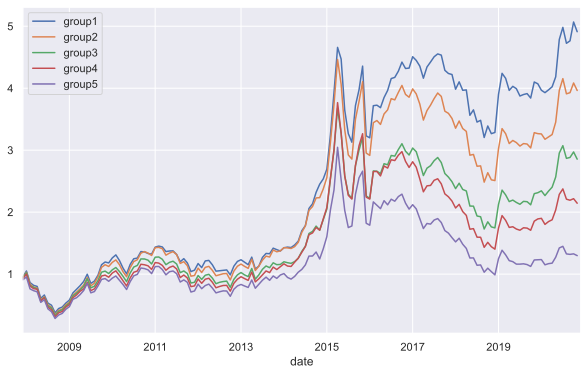

In [82]:
# 我们先在构建long-short之前画一下cumulative
# 发现因子区分的很明显，group1的return最高，而group1是前20%分位的，也就是IVOL最小的一批，由此可说明IVOL和return是显著负相关的，并且区分效果很好
sns.set_theme()
(1+frame.iloc[:,:groups]).cumprod().plot(kind='line', grid=True, figsize=(10,6), legend=True)
plt.savefig('./figures/ivol_portfolio_cumulative.png', dpi=800)

#### **第三步：对投资组合回归计算factor loading并构建tracking portfolio**

**为什么要这么做？因为我们要检验的是IVOL因子带来alpha的能力，而不是beta收益，因此我们要剔除beta的部分，而fama模型解释的就是beta的部分，所以我们要回归后调整factor loading，保证接下来所有的超额收益均不来自于fama的因子，而来自与常数项，就是alpha return。**

In [9]:
# 之前的因子检验直接对划分的组合进行cumulative的plot就可以了，但这里不一样，因为我们不仅是要检验ivol因子的有效性，同时需要去做long-short portfolio
# 而做long-short没有直接作差那么简单，我们要做long-short必须保证factor loading一致，也就是对因子模型的宏观因子的暴露值（系数）一致，这样作差得到的才是常数项的差值
# 我们要检验的就是常数项差值的显著性，控制了factor loading一致后，作差得到的常数项才是alpha（回忆capm和fama french的alpha定义，alpha return就是不能被capm和fama因子模型所解释的收益，能被因子模型解释的收益是beta收益

# 使用单因子构建tracking，系数配比解方程解出来

# 重新来，由于我们还需要进行滑动回归，需要2006年的数据，而上面已经删除了
data = pd.read_csv("./processed_data/case2_IVOL.csv")
data['code'] = data['code'].map(lambda x: '%06d'%x)
data['date'] = pd.to_datetime(data['date'])

# 不去除空值
# data.dropna(subset=['ivol'], inplace=True)
# 每个月根据因子值分组

data.set_index('code', inplace=True)
data['pct'] = data.groupby('date')['ivol'].rank(pct=True)
data.reset_index(inplace=True)
data

,code,date,return,riskfree,market,smb,hml,ivol,pct
0,000001,2006-01-01,0.034202,0.001856,0.103575,-0.000453,-0.021167,NaN,NaN
1,000001,2006-02-01,0.077165,0.001856,0.035575,-0.017297,0.002323,NaN,NaN
2,000001,2006-03-01,-0.068713,0.001856,0.012575,-0.011577,-0.017435,NaN,NaN
3,000001,2006-04-01,0.237049,0.001856,0.117575,-0.044373,0.032558,NaN,NaN
4,000001,2006-05-01,0.114213,0.001856,0.158575,0.120915,-0.012703,NaN,NaN
...,...,...,...,...,...,...,...,...,...
453973,900957,2020-08-01,-0.058722,0.001241,0.017083,0.015042,-0.015729,0.072652,0.306793
453974,900957,2020-09-01,-0.060550,0.001241,-0.055917,-0.019415,0.011966,0.073379,0.312031
453975,900957,2020-10-01,0.005859,0.001241,0.012083,-0.007544,-0.016605,0.073477,0.311685
453976,900957,2020-11-01,0.013592,0.001241,0.042083,-0.036745,0.039776,0.073990,0.318760


In [10]:
# 上面的data是大表，我们需要所有的数据
# 这里再取subdata，保证里面每个股票均有ivol值和group分组，然后计算对应beta的时候再回到大表中去索引

# 使用cut函数快速分组
sub_data = data.dropna(subset=['ivol'])
sub_data['group'] = pd.cut(x=sub_data['pct'], bins=np.linspace(0, 1, num=groups+1), include_lowest=True, labels=(np.arange(groups)+1)).astype(int)
sub_data.sort_values(['group', 'date'], inplace=True)
sub_data

,code,date,return,riskfree,market,smb,hml,ivol,pct,group
2066,000016,2007-12-01,0.154746,0.003169,0.072225,0.070680,0.005325,0.065354,0.018664,1
2872,000021,2007-12-01,0.169220,0.003169,0.072225,0.070680,0.005325,0.088134,0.128684,1
3660,000026,2007-12-01,0.291129,0.003169,0.072225,0.070680,0.005325,0.091502,0.149312,1
4641,000032,2007-12-01,0.229128,0.003169,0.072225,0.070680,0.005325,0.094654,0.179764,1
6339,000045,2007-12-01,0.217949,0.003169,0.072225,0.070680,0.005325,0.077135,0.059921,1
...,...,...,...,...,...,...,...,...,...,...
442526,603998,2020-12-01,-0.049206,0.001241,0.021083,-0.052988,-0.050214,0.140719,0.830893,5
445766,900906,2020-12-01,0.016667,0.001241,0.021083,-0.052988,-0.050214,0.164946,0.903565,5
450327,900933,2020-12-01,-0.015000,0.001241,0.021083,-0.052988,-0.050214,0.189414,0.946394,5
452706,900948,2020-12-01,0.102362,0.001241,0.021083,-0.052988,-0.050214,0.172414,0.919315,5


In [38]:
# 再次进行滑动回归
def get_beta(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    # 若为单因子
    return results.params[1]
    # 若为多因子
    # return results.params

# 滚动回归，神来之笔
def get_regression2(df):
    date = df.iloc[0]['date']
    code = df['code'].unique()
    # 寻找开始时间点
    start = pd.date_range(end=date, periods=24, freq='M').strftime("%Y-%m")[0]
    start = pd.to_datetime(start)
    temp = data[(data['date'] <= date) & (data['code'].isin(code)) & (data['date'] > start)]
    temp.sort_values('date', inplace=True)
    y = temp.groupby('date')[['return']].mean()

    # 单因子模型
    x = temp.groupby('date')[['market']].first()

    # 三因子模型：
    # x = temp.groupby('date')[['market', 'smb', 'hml']].first()

    return get_beta(y, x)
reg2 = sub_data.groupby(['date', 'group']).apply(get_regression2)
reg2

date        group
2007-12-01  1        0.873712
            2        0.884416
            3        0.947133
            4        0.879875
            5        1.033092
                       ...   
2020-12-01  1        0.984059
            2        1.102849
            3        1.157738
            4        1.189423
            5        1.331461
Length: 785, dtype: float64

In [42]:
beta = pd.DataFrame(reg2, columns=['beta'])
beta.reset_index(inplace=True)
beta

,date,group,beta
0,2007-12-01,1,0.873712
1,2007-12-01,2,0.884416
2,2007-12-01,3,0.947133
3,2007-12-01,4,0.879875
4,2007-12-01,5,1.033092
...,...,...,...
780,2020-12-01,1,0.984059
781,2020-12-01,2,1.102849
782,2020-12-01,3,1.157738
783,2020-12-01,4,1.189423


In [64]:
# 使用pivot函数重构
frame_beta = pd.pivot(data=beta, index='date', columns='group', values='beta')
# 重命名列名
for i in range(1,groups+1):
    frame_beta.rename(columns={i:'beta%s'%i}, inplace=True)
frame_beta.to_csv("./results/case2_group_beta.csv", index=True)
frame_beta.head(10)

group,beta1,beta2,beta3,beta4,beta5
date,,,,,
2007-12-01,0.873712,0.884416,0.947133,0.879875,1.033092
2008-01-01,0.801274,0.809396,0.877378,0.809681,0.972605
2008-02-01,0.770551,0.802465,0.863715,0.798510,0.966355
2008-03-01,0.803516,0.843489,0.903082,0.864093,1.025308
2008-04-01,0.806030,0.856177,0.896067,0.897500,1.020022
2008-05-01,0.770411,0.817037,0.845746,0.863293,0.950932
2008-06-01,0.839411,0.877829,0.913120,0.939558,1.006149
2008-07-01,0.828771,0.877358,0.908231,0.937875,1.019905
2008-08-01,0.863703,0.918518,0.959234,0.992930,1.090922


In [52]:
# 每个周期，根据当周期以及以前的数据去计算了因子ivol的值和beta的值，那现在就是根据beta去分配由ivol选出来的组合和riskfree的权重，对应的收益率应该是下期的收益率
# 所以这里计算下周期的股票return和riskfree

sub_data.sort_values(['code', 'date'], inplace=True)
sub_data.set_index('code', inplace=True)
sub_data['next_return'] = sub_data.groupby(level=0)['return'].shift(-1)
sub_data['next_rf'] = sub_data.groupby(level=0)['riskfree'].shift(-1)
sub_data.reset_index(inplace=True)
sub_data

,code,date,return,riskfree,market,smb,hml,ivol,pct,group,next_return,next_rf
0,000001,2007-12-01,0.069845,0.003169,0.072225,0.070680,0.005325,0.119360,0.404715,3,-0.137306,0.003386
1,000001,2008-01-01,-0.137306,0.003386,-0.168775,0.073161,-0.029331,0.118333,0.385382,2,-0.004505,0.003386
2,000001,2008-02-01,-0.004505,0.003386,-0.001775,0.073890,0.020909,0.118353,0.378378,2,-0.149321,0.003386
3,000001,2008-03-01,-0.149321,0.003386,-0.199775,-0.002471,-0.040237,0.115780,0.348998,2,0.050355,0.003386
4,000001,2008-04-01,0.050355,0.003386,0.063225,-0.094830,-0.011102,0.116531,0.372907,2,-0.148211,0.003386
...,...,...,...,...,...,...,...,...,...,...,...,...
360320,900957,2020-08-01,-0.058722,0.001241,0.017083,0.015042,-0.015729,0.072652,0.306793,2,-0.060550,0.001241
360321,900957,2020-09-01,-0.060550,0.001241,-0.055917,-0.019415,0.011966,0.073379,0.312031,2,0.005859,0.001241
360322,900957,2020-10-01,0.005859,0.001241,0.012083,-0.007544,-0.016605,0.073477,0.311685,2,0.013592,0.001241
360323,900957,2020-11-01,0.013592,0.001241,0.042083,-0.036745,0.039776,0.073990,0.318760,2,-0.036398,0.001241


In [65]:
# 上面使用的是下期收益率，但是我们计算factor loading并计算tracking的时候还是使用本期收益率，然后再利用loading去结合下期收益率计算
# 我们需要重新根据分组情况跑一次滑动回归，得到每个月，每个组合的beta值
frame = pd.DataFrame()
for i in range(groups):
    sub_group = sub_data[(sub_data['pct'] <= (i+1)/groups) & (sub_data['pct'] > i/groups)] #用这些%、|符号记得加括号
    frame['group%s'%(i+1)] = sub_group.groupby('date')['next_return'].mean()
frame['next_rf'] = sub_data.groupby('date')['next_rf'].first()
frame.columns.name = 'group'
frame.head(10)

group,group1,group2,group3,group4,group5,next_rf
date,,,,,,
2007-12-01,-0.046994,-0.053557,-0.063363,-0.078511,-0.091856,0.003386
2008-01-01,0.101403,0.085894,0.089708,0.086841,0.048964,0.003386
2008-02-01,-0.178150,-0.186032,-0.201307,-0.194936,-0.201598,0.003386
2008-03-01,-0.052010,-0.055001,-0.036050,-0.051609,-0.037710,0.003386
2008-04-01,-0.020571,-0.020269,-0.032774,-0.012124,-0.025725,0.003386
2008-05-01,-0.239400,-0.247758,-0.248810,-0.248142,-0.237809,0.003386
2008-06-01,0.086429,0.086387,0.091508,0.084102,0.077740,0.003386
2008-07-01,-0.195659,-0.206079,-0.218744,-0.244258,-0.251457,0.003386
2008-08-01,-0.065511,-0.078853,-0.073891,-0.089055,-0.105488,0.003386


In [71]:
# 合并beta和下周期的收益率
final = pd.merge(frame, frame_beta, on='date')
final.to_csv("./results/case2_group_rf_beta.csv", index=True)
final.head(20)

group,group1,group2,group3,group4,group5,next_rf,beta1,beta2,beta3,beta4,beta5
date,,,,,,,,,,,
2007-12-01,-0.046994,-0.053557,-0.063363,-0.078511,-0.091856,0.003386,0.873712,0.884416,0.947133,0.879875,1.033092
2008-01-01,0.101403,0.085894,0.089708,0.086841,0.048964,0.003386,0.801274,0.809396,0.877378,0.809681,0.972605
2008-02-01,-0.178150,-0.186032,-0.201307,-0.194936,-0.201598,0.003386,0.770551,0.802465,0.863715,0.798510,0.966355
2008-03-01,-0.052010,-0.055001,-0.036050,-0.051609,-0.037710,0.003386,0.803516,0.843489,0.903082,0.864093,1.025308
2008-04-01,-0.020571,-0.020269,-0.032774,-0.012124,-0.025725,0.003386,0.806030,0.856177,0.896067,0.897500,1.020022
2008-05-01,-0.239400,-0.247758,-0.248810,-0.248142,-0.237809,0.003386,0.770411,0.817037,0.845746,0.863293,0.950932
2008-06-01,0.086429,0.086387,0.091508,0.084102,0.077740,0.003386,0.839411,0.877829,0.913120,0.939558,1.006149
2008-07-01,-0.195659,-0.206079,-0.218744,-0.244258,-0.251457,0.003386,0.828771,0.877358,0.908231,0.937875,1.019905
2008-08-01,-0.065511,-0.078853,-0.073891,-0.089055,-0.105488,0.003386,0.863703,0.918518,0.959234,0.992930,1.090922


In [74]:
# 计算tracking portfolio的下周期回报率
tracking = pd.DataFrame()
for i in range(1, groups+1):
    tracking['P%s'%i] = (1/final['beta%s'%i]) * final['group%s'%i] + (1/final['beta%s'%i]) * final['next_rf']
# 删除最后一行，也就是下周期收益率为空值的情况
tracking.dropna(inplace=True)
tracking.to_csv("./results/case2_tracking_portfolio.csv", index=True)
tracking.head(10)

,P1,P2,P3,P4,P5
date,,,,,
2007-12-01,-0.049912,-0.056728,-0.063325,-0.085382,-0.085637
2008-01-01,0.130778,0.110304,0.106105,0.111435,0.053825
2008-02-01,-0.226804,-0.227606,-0.229150,-0.239885,-0.205113
2008-03-01,-0.060514,-0.061192,-0.036170,-0.055807,-0.033476
2008-04-01,-0.021321,-0.019719,-0.032796,-0.009736,-0.021901
2008-05-01,-0.306349,-0.299095,-0.290186,-0.283514,-0.246519
2008-06-01,0.106998,0.102268,0.103922,0.093116,0.080630
2008-07-01,-0.231998,-0.231026,-0.237118,-0.256828,-0.243229
2008-08-01,-0.071928,-0.082161,-0.073502,-0.086279,-0.093592


**画图**

线本身的颜色调节靠colormap，而背景板和整体的模版方向看style

In [2]:
tracking = pd.read_csv("./results/case2_tracking_portfolio.csv")
tracking.set_index('date', inplace=True)
tracking.head()

,P1,P2,P3,P4,P5
date,,,,,
2007-12-01,-0.049912,-0.056728,-0.063325,-0.085382,-0.085637
2008-01-01,0.130778,0.110304,0.106105,0.111435,0.053825
2008-02-01,-0.226804,-0.227606,-0.229150,-0.239885,-0.205113
2008-03-01,-0.060514,-0.061192,-0.036170,-0.055807,-0.033476
2008-04-01,-0.021321,-0.019719,-0.032796,-0.009736,-0.021901


In [165]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


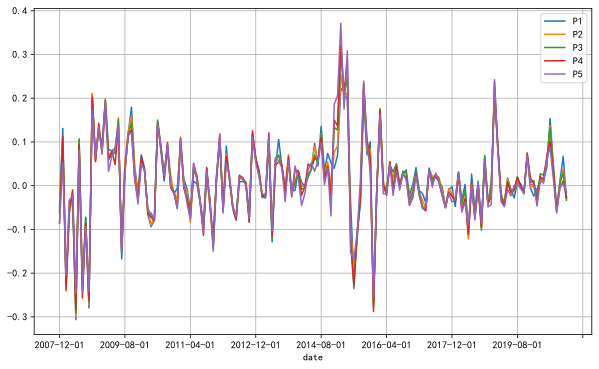

In [6]:
tracking.plot(kind='line', grid=True,figsize=(10,6), legend=True)
plt.savefig("./figures/tracking_return.png", dpi=800)

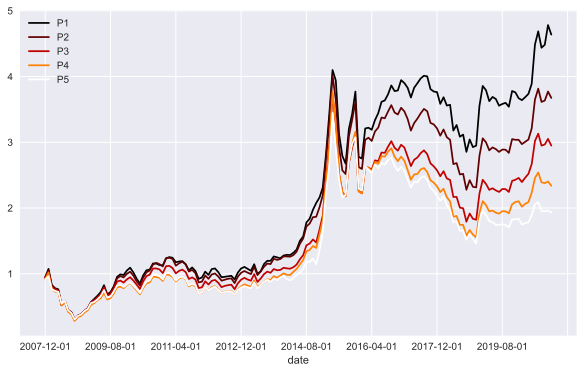

In [13]:
plt.style.use('seaborn')
(1+tracking).cumprod().plot(kind='line',colormap = 'gist_heat', figsize=(10,6), legend=True)
plt.savefig("./figures/tracking_cumulative.png", dpi=800)

**tracking portfolio结果和此前直接不回归去除三因子影响的总portfolio结果一致，IVOL和return呈现显著的负相关性，IVOL越低，周期return越高。**

**Construct long-short portfolios**

In [17]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


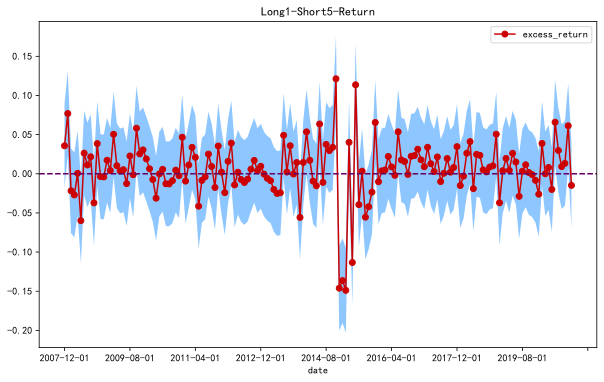

In [5]:
# 做多组合1，做空组合5
excess = tracking['P1'] - tracking['P5']
excess.plot(kind='line', color='#cc0000', figsize=(10,6), marker='o', label='excess_return')

# 填充1.5倍标准差
lower = np.array(excess) + 1.5*excess.std()
upper = np.array(excess) - 1.5*excess.std()
plt.fill_between(x=excess.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
plt.title('Long1-Short5-Return')
plt.axhline(y = 0, color='#660066', linestyle='--')
plt.legend(loc=1)
plt.savefig('./figures/arbitrage_1_5.png', dpi=800)

Text(0.5, 1.0, '做多1-做空5组合累积收益率')

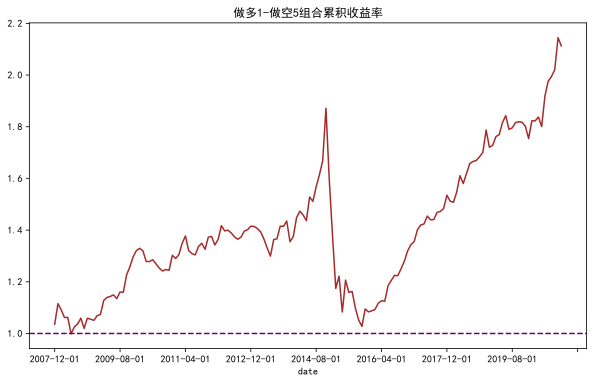

In [8]:
# 累积收益
cum = (1+excess).cumprod()
cum.plot(kind='line', figsize=(10,6), color='brown')

plt.axhline(y = 1, color='#660066', linestyle='--')
plt.title('做多1-做空5组合累积收益率')
plt.savefig('./figures/arbitrage_1_5_cum.png', dpi=800)

In [9]:
# 检验显著性
[excess.mean() - 1.96*excess.std()/np.sqrt(excess.shape[0]), excess.mean() + 1.96*excess.std()/np.sqrt(excess.shape[0])]
[excess.mean() - 1.645*excess.std()/np.sqrt(excess.shape[0]), excess.mean() + 1.645*excess.std()/np.sqrt(excess.shape[0])]

[0.0007197762026921965, 0.010220926524560367]

**结论：做多1，做空5的策略arbitrage收益在10%下显著**

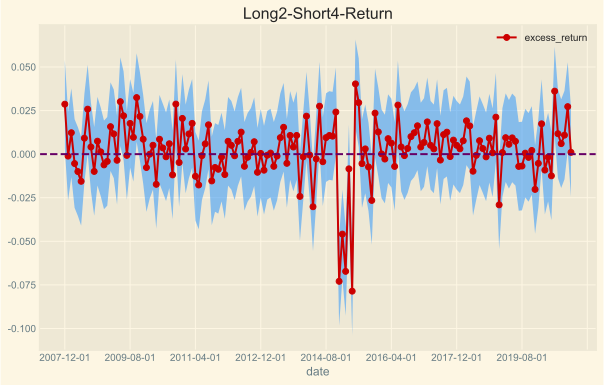

In [23]:
# 做多组合2，做空组合4
plt.style.use('Solarize_Light2')
excess = tracking['P2'] - tracking['P4']
excess.plot(kind='line', color='#cc0000', figsize=(10,6), marker='o', label='excess_return')

# 填充1.5倍标准差
lower = np.array(excess) + 1.5*excess.std()
upper = np.array(excess) - 1.5*excess.std()
plt.fill_between(x=excess.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
plt.title('Long2-Short4-Return')
plt.axhline(y = 0, color='#660066', linestyle='--')
plt.legend(loc=1)
plt.savefig('./figures/arbitrage_2_4.png', dpi=800)

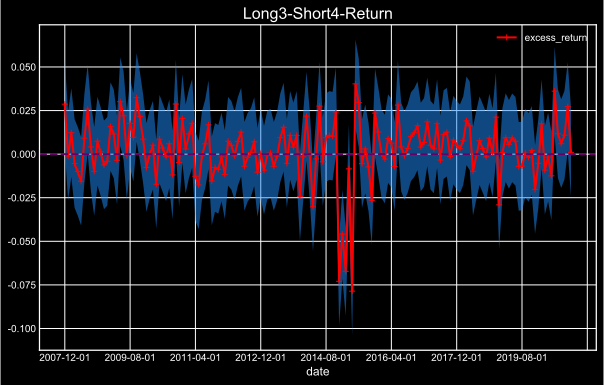

In [28]:
# 做多组合3，做空组合4
plt.style.use('dark_background')
excess = tracking['P2'] - tracking['P4']
excess.plot(kind='line', color='r', figsize=(10,6), marker='+', label='excess_return')

# 填充1.5倍标准差
lower = np.array(excess) + 1.5*excess.std()
upper = np.array(excess) - 1.5*excess.std()
plt.fill_between(x=excess.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
plt.title('Long3-Short4-Return')
plt.axhline(y = 0, color='#660066', linestyle='--')
plt.legend(loc=1)
plt.savefig('./figures/arbitrage_3_4.png', dpi=800)

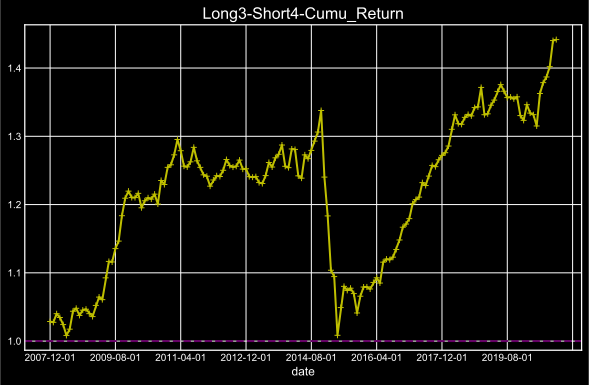

In [35]:
# 累积收益
(1+excess).cumprod().plot(kind='line', figsize=(10,6), color='y', marker='+')
plt.axhline(y = 1, color='#660066', linestyle='--')
plt.title('Long3-Short4-Cumu_Return')
plt.savefig('./figures/arbitrage_3_4_cum.png', dpi=800)

In [30]:
[excess.mean() - 1.96*excess.std()/np.sqrt(excess.shape[0]), excess.mean() + 1.96*excess.std()/np.sqrt(excess.shape[0])]
[excess.mean() - 1.645*excess.std()/np.sqrt(excess.shape[0]), excess.mean() + 1.645*excess.std()/np.sqrt(excess.shape[0])]

[0.0002618529890225799, 0.004723972735422526]

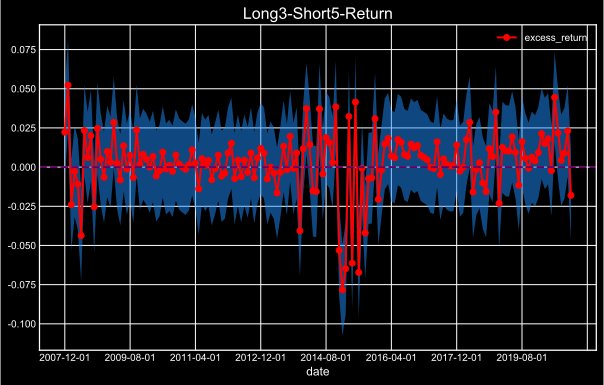

In [42]:
# 做多组合3，做空组合5
plt.style.use('dark_background')
excess = tracking['P3'] - tracking['P5']
excess.plot(kind='line', color='r', figsize=(10,6), marker='o', label='excess_return')

# 填充1.5倍标准差
lower = np.array(excess) + 1.5*excess.std()
upper = np.array(excess) - 1.5*excess.std()
plt.fill_between(x=excess.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
plt.title('Long3-Short5-Return')
plt.axhline(y = 0, color='#660066', linestyle='--')
plt.legend(loc=1)
plt.savefig('./figures/arbitrage_3_5.png', dpi=800)
